>       Keep alive on Google Colab

In [ ]:
# #keep alive (right click 'inspect', then 'console', clear console and paste the below code)
# function ConnectButton(){
#     console.log("Connect pushed"); 
#     document.querySelector("#top-toolbar > colab-connect-button").shadowRoot.querySelector("#connect").click() 
# }

# var colab = setInterval(ConnectButton,600000);   #to connect for 10 mins

# #clearInterval(connect)     #to clear the keep alive interval

>       Mount drive and Install Libraries

In [ ]:
# # Mount Google Drive
# from google.colab import drive
# drive.mount('/content/drive') 

# #install libraries 
# !pip install -q -r '/content/drive/MyDrive/Colab Notebooks/requirements.txt' 


<br>Table of Content:
* [Import Libraries](#1)
* [Load Data](#2)
* [Data Preprocessing](#3)
* [Selecting and Training the Model](#4) 
    * [Logistic Regression](#4a)
    * [Support Vector Machines (SVM)](#4b)
    * [Decision Tree](#4c)
* [Model Optimization: Hyperparameter Tuning](#5) 
* [Feature Selection and Retraining Model](#6)
* [Saving the Model](#7)

<a id="1"></a> <br>
## Import Libraries

In [1]:
# Data Analysis      
import os
import pandas as pd          # data analysis library for handling structured data  
import numpy as np           # mathematical library for working with numerical data
from pandas.plotting import parallel_coordinates 
from functions import *

# Visualization
import matplotlib.pyplot as plt     # data visualization library for creating graphs and charts
%matplotlib inline
import seaborn as sns        # data visualization library based on matplotlib for creating more attractive visualizations
import missingno as msno    #visualize missing data

from joblib import load, dump
import optuna

# Ignore warnings
import warnings
warnings.filterwarnings("ignore") 

pd.set_option('display.max_rows', 15)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

<a id="2"></a> <br>
## Load Data

In [7]:
import pandas as pd
import numpy as np

def load_dorothea_data(data_filename, label_filename, nrows, ncols):
    # Initialize a zero matrix
    data_matrix = np.zeros((nrows, ncols), dtype=int)

    # Read the data file
    with open(data_filename, 'r') as file:
        for i, line in enumerate(file):
            # Convert line to integers and set the corresponding indices to 1
            indices = np.fromstring(line, dtype=int, sep=' ') - 1
            data_matrix[i, indices] = 1

    # Load labels
    labels = pd.read_csv(label_filename, header=None).values.flatten()

    return data_matrix, labels

# Specify the number of rows and columns
nrows, ncols = 800, 100000  # Adjust nrows for different datasets

# Load training data
train_data, train_labels = load_dorothea_data('data/dorothea_train.data', 'data/dorothea_train.labels', nrows, ncols)
train_data_df = pd.DataFrame(train_data, columns=["feature_" + str(i) for i in range(1, train_data.shape[1]+1)])

# Load validation data
valid_data, valid_labels = load_dorothea_data('data/dorothea_valid.data', 'data/dorothea_valid.labels', 350, ncols)
valid_data_df = pd.DataFrame(valid_data, columns=["feature_" + str(i) for i in range(1, valid_data.shape[1]+1)])


>>      Data Understanding

In [3]:
print(f"Train Features: {train_data.shape[0]} rows and {train_data.shape[1]} columns")
print(f"Train Labels: {train_labels.shape[0]} instances")
print(f"Validation Features: {valid_data.shape[0]} rows and {valid_data.shape[1]} columns")
print(f"Validation Labels: {valid_labels.shape[0]} instances")

Train Features: 800 rows and 100000 columns
Train Labels: 800 instances
Validation Features: 350 rows and 100000 columns
Validation Labels: 350 instances


In [4]:
train_data_df.info()    # Train Dataset
print( )
valid_data_df.info()    # Validation Dataset

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 800 entries, 0 to 799
Columns: 100000 entries, feature_1 to feature_100000
dtypes: int32(100000)
memory usage: 305.2 MB

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 350 entries, 0 to 349
Columns: 100000 entries, feature_1 to feature_100000
dtypes: int32(100000)
memory usage: 133.5 MB


<a id="3"></a> <br>
## Data Preprocessing

>       Data Cleaning: Check for missing values

In [ ]:
# Check for missing values
missing_value_counts = train_data_df.isnull().sum()
if missing_value_counts.sum() == 0:
    print("No Missing Values")
else:
    print({col: missing for col, missing in missing_value_counts.items() if missing > 0})


No Missing Values


>       Data Transformation - Standardization

Since the Dorothea dataset consists of binary data (0s and 1s), the features are already on the same scale. Standardization would not be meaningful because the 0s and 1s represent the absence or presence of a feature, rather than a quantitative measurement.

In addition, the dataset is sparse, meaning that most of the values are zero. Standardizing would shift the 0s away from zero, which would eliminate the sparsity of the dataset.

>       Data Imbalance

We could fix the data imbalance at this stage, or use a stratified fold cross validation method when building the model to account for the data imbalance

The Stratified K-fold cross-validation ensures that each fold has an approximately equal distribution of target classes, making it suitable for imbalanced datasets.

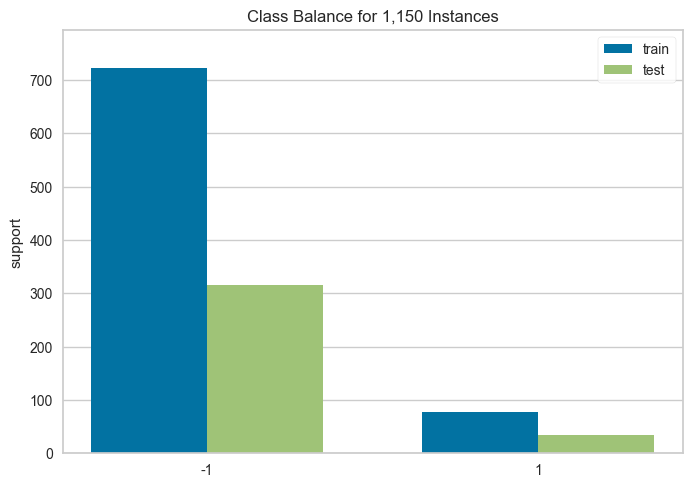

<AxesSubplot: title={'center': 'Class Balance for 1,150 Instances'}, ylabel='support'>

In [4]:
from yellowbrick.target import ClassBalance 


classes = [-1, 1]
# Instantiate the visualizer
visualizer = ClassBalance(labels=classes)
visualizer.fit(train_labels, valid_labels)        # Fit the data to the visualizer (you can also use visualizer.fit(y))
visualizer.show()                       # Finalize and render the figure

<a id="4"></a> <br>
## Selecting and Training the Model

| Classification Algorithms | Characteristics |
|---------------------------|-----------------|
| Logistic Regression       | - Simple to understand and implement for binary data<br>- Useful to find relationships between features |
| Support Vector Machine    | - Effective with high dimensional data<br>- Relatively computationally cheap |
| Decision Tree             | - Breakdown of complex data into smaller sections<br>- Simple interpretability |


<a id="4a"></a> <br>
### Training a Logistic Regression Model

In [3]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import make_scorer, roc_auc_score, confusion_matrix


def runLR_CV(data_X, data_y, C=1.0, penalty="l1"):
    model = LogisticRegression(C=C, penalty=penalty, solver='liblinear', max_iter=1000)
    
    # Prepare cross validation
    skf = StratifiedKFold(n_splits=10)
    auc_scores_train = []
    auc_scores_test = []
    
    for train_index, test_index in skf.split(data_X, data_y):
        # Split data into training and test sets for current fold
        train_X, test_X = data_X[train_index], data_X[test_index]
        train_y, test_y = data_y[train_index], data_y[test_index]
        
        # Fit the model
        model.fit(train_X, train_y)
        
        # Calculate predictions
        train_preds = model.predict_proba(train_X)[:, 1]
        test_preds = model.predict_proba(test_X)[:, 1]
        
        # Calculate ROC AUC and append to list
        auc_train = roc_auc_score(train_y, train_preds)
        auc_test = roc_auc_score(test_y, test_preds)
        auc_scores_train.append(auc_train)
        auc_scores_test.append(auc_test)
    
    # Calculate the average AUC scores across all folds
    avg_auc_train = sum(auc_scores_train) / len(auc_scores_train)
    avg_auc_test = sum(auc_scores_test) / len(auc_scores_test)
    print("Average Train AUC:", avg_auc_train)
    print("Average Test AUC:", avg_auc_test)
    
    return avg_auc_train, avg_auc_test, model

# Assuming train_X and train_y are your data and labels
avg_auc_train, avg_auc_test, log_model = runLR_CV(train_data, train_labels, C=1.0, penalty="l1")


Average Train AUC: 1.0
Average Test AUC: 0.8787963415959992


Accuracy: 93.14%
Precision: 75.00%
Sensitivity (Recall): 44.12%
Specificity: 98.42%
Fscore: 55.56%
Average precision: 38.52%
G-Mean: 65.89%
ROC AUC: 80.09%


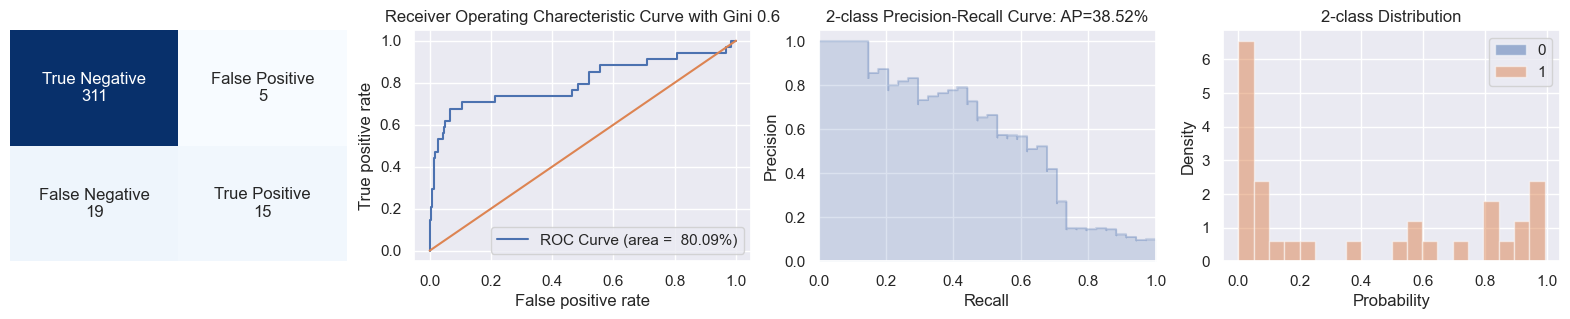

In [4]:
# Performance Report - Logistic Regression

y_pred,ACC,PC,RC,FS,AP,roc_auc,gini = print_classification_performance2class_report(log_model,valid_data,valid_labels)

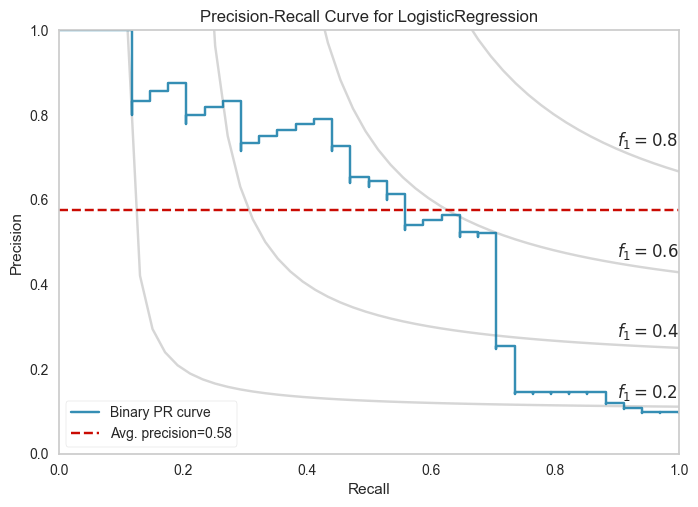

<AxesSubplot: title={'center': 'Precision-Recall Curve for LogisticRegression'}, xlabel='Recall', ylabel='Precision'>

In [10]:
#Precision - Recall Curve
from yellowbrick.classifier import PrecisionRecallCurve

# Create the visualizer, fit, score, and show it
viz = PrecisionRecallCurve(log_model, per_class=True,
                            cmap="Set1", iso_f1_curves=True, 
                            micro=False)
viz.fit(train_data, train_labels)
viz.score(valid_data, valid_labels)
viz.show()

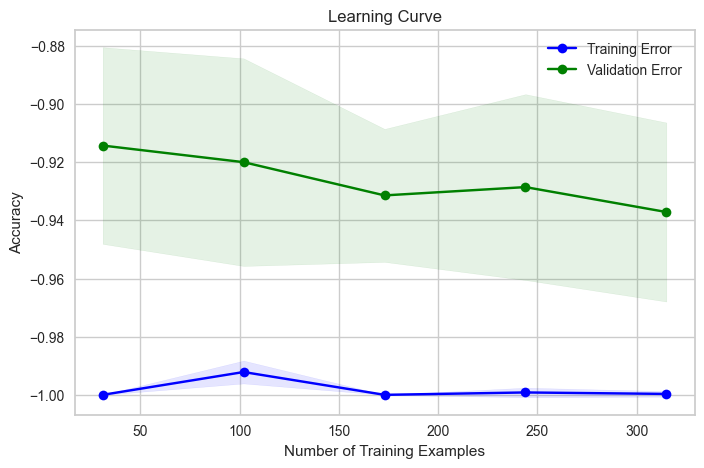

In [31]:
train_sizes = np.linspace(0.1, 1.0, 5)
cv = 10

train_sizes, train_mean, train_std, test_mean, test_std  = cv_learning_curve(log_model, train_data, train_labels, cv, train_sizes)

<a id="4b"></a> <br>
### Training a Support Vector Machine (SVM)

In [5]:
from sklearn.svm import SVC

### Running SVM
def runSVC_CV(data_X, data_y, C=1.0, kernels=["rbf", "linear", "poly"]):
    results = {}

    skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

    for kernel_choice in kernels:
        model = SVC(C=C, kernel=kernel_choice, probability=True)
        auc_scores_train = []
        auc_scores_test = []

        for train_index, test_index in skf.split(data_X, data_y):
            train_X, test_X = data_X[train_index], data_X[test_index]
            train_y, test_y = data_y[train_index], data_y[test_index]
            
            model.fit(train_X, train_y)
            train_preds = model.predict_proba(train_X)[:, 1]
            test_preds = model.predict_proba(test_X)[:, 1]

            auc_train = roc_auc_score(train_y, train_preds)
            auc_test = roc_auc_score(test_y, test_preds)
            auc_scores_train.append(auc_train)
            auc_scores_test.append(auc_test)

        avg_auc_train = np.mean(auc_scores_train)
        avg_auc_test = np.mean(auc_scores_test)
        print(f"Kernel: {kernel_choice} | Average Train AUC: {avg_auc_train:.4f} | Average Test AUC: {avg_auc_test:.4f}")

        results[kernel_choice] = {
            'avg_auc_train': avg_auc_train, 
            'avg_auc_test': avg_auc_test, 
            'model': model
        }
    
    return results

# Example usage:
results = runSVC_CV(train_data, train_labels, C=1.0)


Kernel: rbf | Average Train AUC: 1.0000 | Average Test AUC: 0.9126
Kernel: linear | Average Train AUC: 1.0000 | Average Test AUC: 0.9402
Kernel: poly | Average Train AUC: 1.0000 | Average Test AUC: 0.9371


In [7]:
# Separate variables for each kernel model
rbf_model = results['rbf']['model']
linear_model = results['linear']['model']
poly_model = results['poly']['model']

Accuracy: 90.29%
Precision: 0.00%
Sensitivity (Recall): 0.00%
Specificity: 100.00%
Fscore: 0.00%
Average precision: 9.71%
G-Mean: 0.00%
ROC AUC: 91.62%


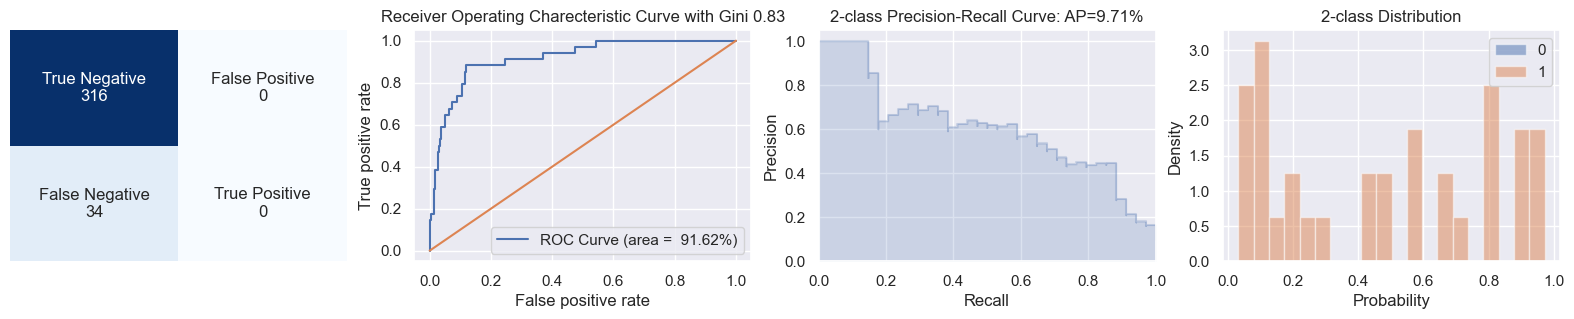

In [4]:
# Performance Report - Support Vector Machine (SVM) with rbf kernel

y_pred,ACC,PC,RC,FS,AP,roc_auc,gini = print_classification_performance2class_report(rbf_model,valid_data,valid_labels)

Accuracy: 92.29%
Precision: 88.89%
Sensitivity (Recall): 23.53%
Specificity: 99.68%
Fscore: 37.21%
Average precision: 28.34%
G-Mean: 48.43%
ROC AUC: 90.49%


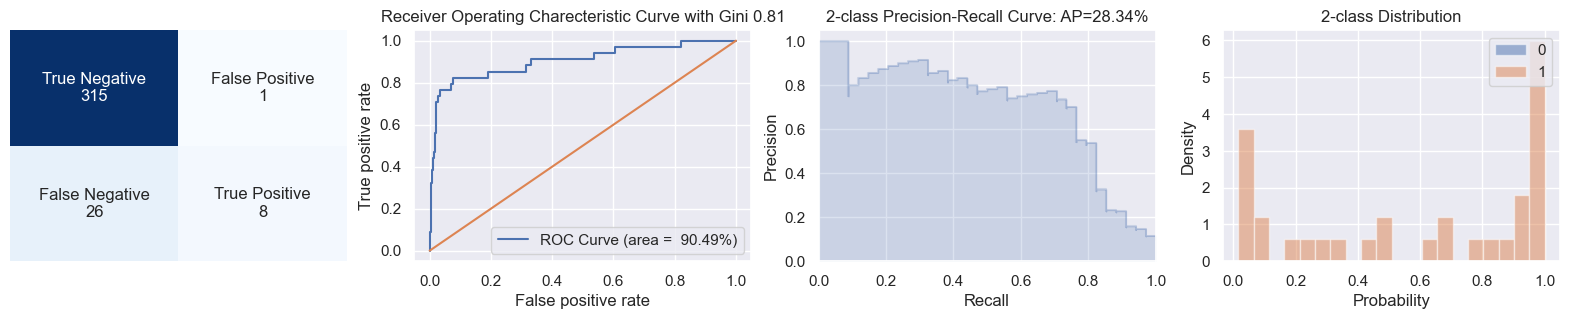

In [9]:
# Performance Report - Support Vector Machine (SVM) - linear kernel

y_pred,ACC,PC,RC,FS,AP,roc_auc,gini = print_classification_performance2class_report(linear_model,valid_data,valid_labels)

Accuracy: 90.29%
Precision: 0.00%
Sensitivity (Recall): 0.00%
Specificity: 100.00%
Fscore: 0.00%
Average precision: 9.71%
G-Mean: 0.00%
ROC AUC: 91.70%


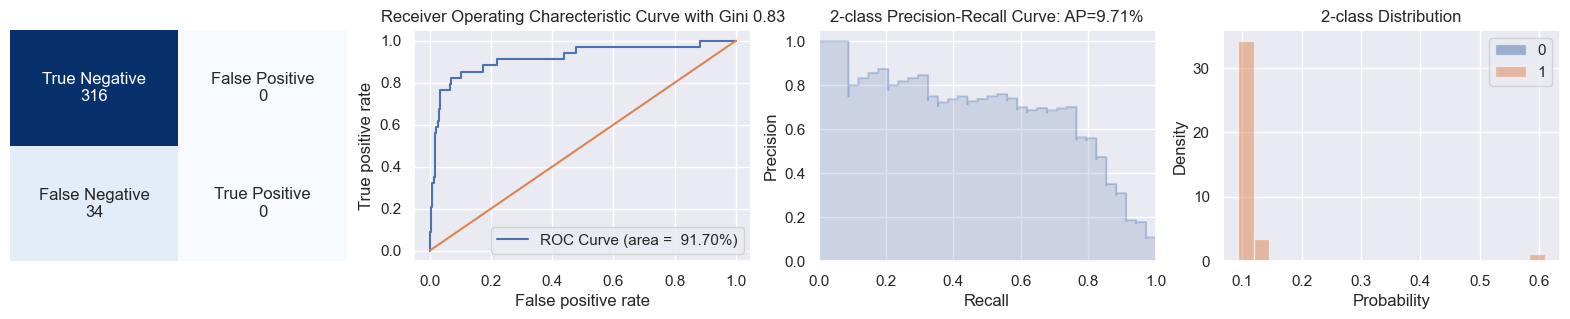

In [6]:
# Performance Report - Support Vector Machine (SVM) - polynomial kernel

y_pred,ACC,PC,RC,FS,AP,roc_auc,gini = print_classification_performance2class_report(poly_model,valid_data,valid_labels)

<a id="4c"></a> <br>
### Training a Decision Tree Model

In [5]:
from sklearn.tree import DecisionTreeClassifier


def runDT_CV(data_X, data_y, criterion="gini", depth=None, min_split=2, min_leaf=1):
    results = {}

    skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
    auc_scores_train = []
    auc_scores_test = []

    for train_index, test_index in skf.split(data_X, data_y):
        train_X, test_X = data_X[train_index], data_X[test_index]
        train_y, test_y = data_y[train_index], data_y[test_index]

        model = DecisionTreeClassifier(
            criterion=criterion,
            max_depth=depth,
            min_samples_split=min_split,
            min_samples_leaf=min_leaf,
        )
        model.fit(train_X, train_y)
        train_preds = model.predict_proba(train_X)[:, 1]
        test_preds = model.predict_proba(test_X)[:, 1]

        auc_train = roc_auc_score(train_y, train_preds)
        auc_test = roc_auc_score(test_y, test_preds)
        auc_scores_train.append(auc_train)
        auc_scores_test.append(auc_test)

    avg_auc_train = np.mean(auc_scores_train)
    avg_auc_test = np.mean(auc_scores_test)
    print(f"Average Train AUC: {avg_auc_train:.4f} | Average Test AUC: {avg_auc_test:.4f}")

    results = {
        'avg_auc_train': avg_auc_train, 
        'avg_auc_test': avg_auc_test, 
        'model': model
    }
    
    return results

results = runDT_CV(train_data, train_labels, criterion="gini", depth=None, min_split=2, min_leaf=1) 
dt_model = results['model'] 


Average Train AUC: 1.0000 | Average Test AUC: 0.7519


Accuracy: 92.29%
Precision: 60.61%
Sensitivity (Recall): 58.82%
Specificity: 95.89%
Fscore: 59.70%
Average precision: 39.65%
G-Mean: 75.10%
ROC AUC: 77.35%


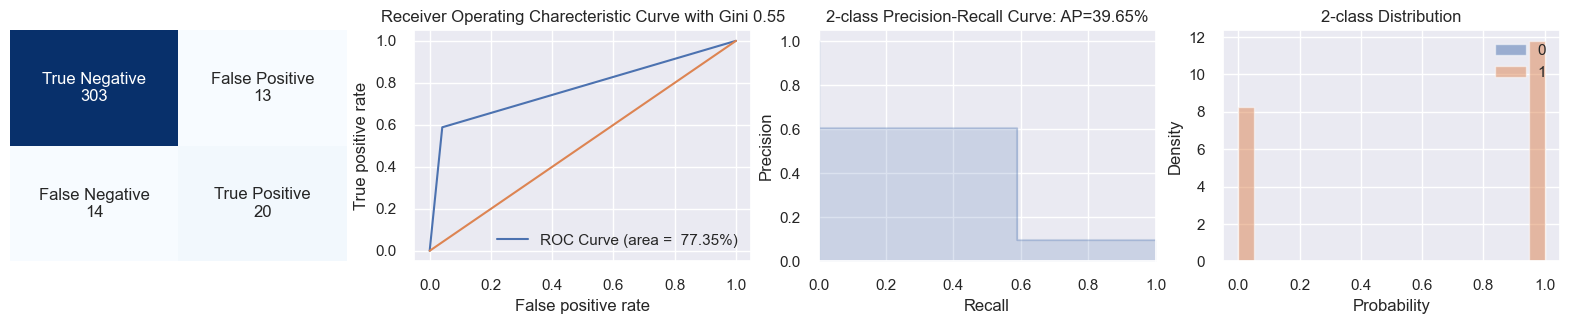

In [6]:
# Performance Report - Decision Tree Model

y_pred,ACC,PC,RC,FS,AP,roc_auc,gini = print_classification_performance2class_report(dt_model,valid_data,valid_labels) 

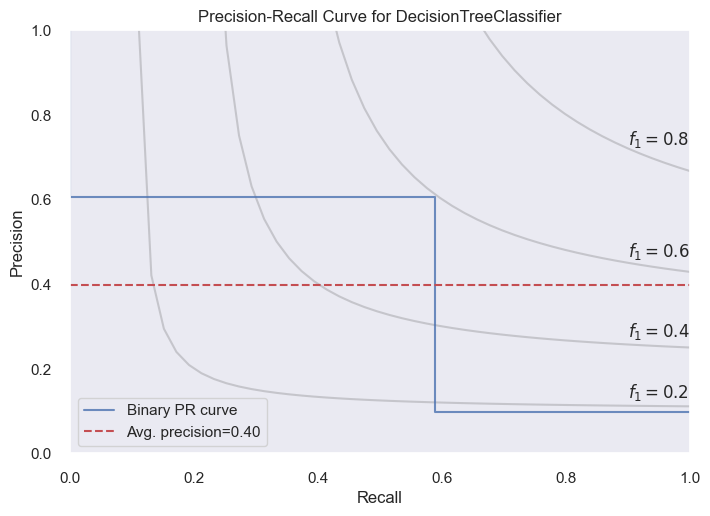

<AxesSubplot: title={'center': 'Precision-Recall Curve for DecisionTreeClassifier'}, xlabel='Recall', ylabel='Precision'>

In [7]:
#Precision - Recall Curve
from yellowbrick.classifier import PrecisionRecallCurve

# Create the visualizer, fit, score, and show it
viz = PrecisionRecallCurve(dt_model, per_class=True,
                            cmap="Set1", iso_f1_curves=True, 
                            micro=False)
viz.fit(train_data, train_labels)
viz.score(valid_data, valid_labels)
viz.show()

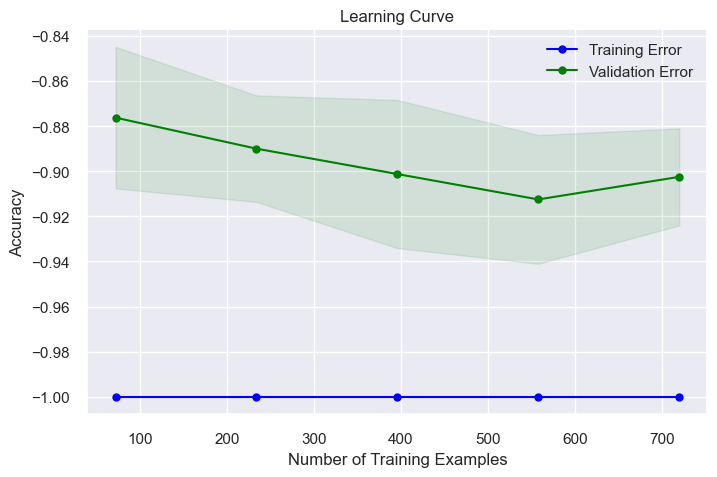

In [8]:
train_sizes = np.linspace(0.1, 1.0, 5)
cv = 10

train_sizes, train_mean, train_std, test_mean, test_std  = cv_learning_curve(dt_model, train_data, train_labels, cv, train_sizes)

>       Save the Model

In [22]:
from joblib import dump, load

# Save the model to a file
dump(log_model, 'models/initial_model/logistic_regression_model.joblib')
dump(rbf_model, 'models/initial_model/support_vector_rbf.joblib')
dump(linear_model, 'models/initial_model/support_vector_linear.joblib')
dump(poly_model, 'models/initial_model/support_vector_poly.joblib')
dump(dt_model, 'models/initial_model/decision_tree_model.joblib')


['models/initial_model/decision_tree_model.joblib']

<a id="5"></a> <br>
## Model Optimization: Hyperparameter Tuning

>       Logistic Regression - Hyperparameter Optimization

In [3]:
from sklearn.linear_model import LogisticRegression

LogisticRegression().get_params()

{'C': 1.0,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 100,
 'multi_class': 'auto',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': None,
 'solver': 'lbfgs',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

In [12]:
#Automatic Hyperparameter Optimization using Optuna

import optuna 
import logging


# Set the logging level for Optuna to WARNING
# logging.getLogger('optuna').setLevel(logging.WARNING) 

# Define your objective function
def objective(trial):
    # Define the search space for the key hyperparameters
    C = trial.suggest_loguniform('C', 0.1, 10)
    solver = trial.suggest_categorical('solver', ['liblinear', 'saga'])
    # penalty = trial.suggest_categorical('penalty', ['l1', 'l2'])
    penalty = 'l2' 
    max_iter = trial.suggest_int('max_iter', 100, 1000)
        
    # Create the Logistic Regression model with the adjusted solver
    model = LogisticRegression(C=C, penalty=penalty, solver=solver, max_iter=max_iter)

    # Perform cross-validation and compute the average AUC score
    scores = cross_val_score(model, train_data, train_labels, scoring='roc_auc', n_jobs=-1, cv=10)
    avg_auc_test = np.mean(scores)
  
    return avg_auc_test

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

trial = study.best_trial

print('Accuracy: {}'.format(trial.value))
print("Best hyperparameters: {}".format(trial.params))


[I 2023-12-06 00:34:21,237] A new study created in memory with name: no-name-122e0d27-2013-4969-a172-eb6829c53ff8
[I 2023-12-06 01:24:15,139] Trial 0 finished with value: 0.9158791313328984 and parameters: {'C': 0.43871973218177995, 'solver': 'saga', 'max_iter': 672}. Best is trial 0 with value: 0.9158791313328984.
[I 2023-12-06 01:24:24,163] Trial 1 finished with value: 0.9175741329636876 and parameters: {'C': 0.765441731695743, 'solver': 'liblinear', 'max_iter': 980}. Best is trial 1 with value: 0.9175741329636876.
[I 2023-12-06 01:24:35,399] Trial 2 finished with value: 0.9172269107414655 and parameters: {'C': 0.4709311291440508, 'solver': 'liblinear', 'max_iter': 346}. Best is trial 1 with value: 0.9175741329636876.
[I 2023-12-06 01:24:43,411] Trial 3 finished with value: 0.9171827435312023 and parameters: {'C': 0.23265436012267934, 'solver': 'liblinear', 'max_iter': 963}. Best is trial 1 with value: 0.9175741329636876.
[I 2023-12-06 01:24:52,954] Trial 4 finished with value: 0.917

In [24]:
# Extracting the best hyperparameters
best_hyperparams = study.best_trial.params

best_C_log = best_hyperparams['C']
best_penalty = best_hyperparams['penalty']
best_solver = best_hyperparams['solver']
best_max_iter = best_hyperparams['max_iter']


print('Best C (log): {}'.format(best_C_log))
print('Best penalty: {}'.format(best_penalty))
print('Best solver: {}'.format(best_solver))
print('Best max iter: {}'.format(best_max_iter))


log_tuned_model = LogisticRegression(C=best_C_log, penalty=best_penalty, solver=best_solver, max_iter=best_max_iter)

log_tuned_model.fit(train_data, train_labels)


dump(log_tuned_model, 'models/tuned_model/tuned_logistic_regression.joblib')



Best C (log): 6.56
Best penalty: l1
Best solver: liblinear
Best max iter: 356


['models/tuned_model/tuned_logistic_regression.joblib']

Accuracy: 92.57%
Precision: 70.00%
Sensitivity (Recall): 41.18%
Specificity: 98.10%
Fscore: 51.85%
Average precision: 34.54%
G-Mean: 63.56%
ROC AUC: 83.82%


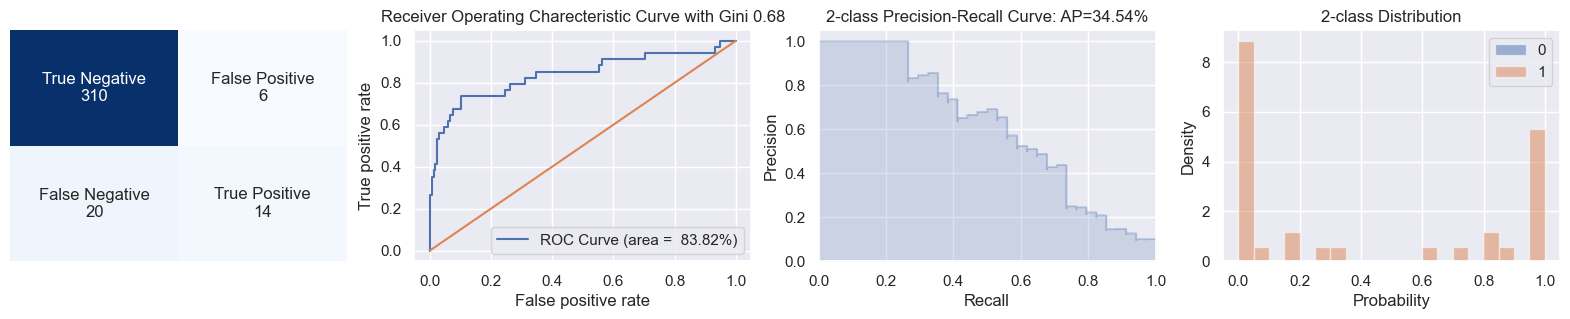

In [25]:
y_pred,ACC,PC,RC,FS,AP,roc_auc,gini = print_classification_performance2class_report(log_tuned_model,valid_data,valid_labels)

>       Support Vector Machines (SVC) - Hyperparameter Optimization

In [3]:
from sklearn.svm import SVC

SVC().get_params()

{'C': 1.0,
 'break_ties': False,
 'cache_size': 200,
 'class_weight': None,
 'coef0': 0.0,
 'decision_function_shape': 'ovr',
 'degree': 3,
 'gamma': 'scale',
 'kernel': 'rbf',
 'max_iter': -1,
 'probability': False,
 'random_state': None,
 'shrinking': True,
 'tol': 0.001,
 'verbose': False}

In [6]:
# Set the logging level for Optuna to WARNING
# logging.getLogger('optuna').setLevel(logging.WARNING) 

def objective(trial):
    # Define the hyperparameters' search space
    C = trial.suggest_loguniform('C', 1e-4, 1e4)
    kernel = trial.suggest_categorical('kernel', ['rbf', 'poly'])
    gamma = trial.suggest_categorical('gamma', ['scale', 'auto'])
    degree = trial.suggest_int('degree', 1, 5) if kernel == 'poly' else 3  # degree is only used for 'poly' kernel

    # Create the SVM model
    model = SVC(C=C, kernel=kernel, gamma=gamma, degree=degree, probability=True)

    # Perform cross-validation and compute the average AUC score
    scores = cross_val_score(model, train_data, train_labels, scoring='roc_auc', n_jobs=-1, cv=10)
    avg_auc_test = np.mean(scores)

    return avg_auc_test

# Create and run the study
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

# Best hyperparameters
best_hyperparams = study.best_trial.params
# print('Best Hyperparameters:', best_hyperparams)


[I 2023-12-05 13:42:28,833] A new study created in memory with name: no-name-84788ef9-1419-47de-a52a-2c692a404bbf
[I 2023-12-05 13:49:26,910] Trial 0 finished with value: 0.8457477168949772 and parameters: {'C': 0.00021872972894263523, 'kernel': 'poly', 'gamma': 'scale', 'degree': 5}. Best is trial 0 with value: 0.8457477168949772.
[I 2023-12-05 13:56:48,122] Trial 1 finished with value: 0.8630296667753861 and parameters: {'C': 0.000174377464488212, 'kernel': 'poly', 'gamma': 'scale', 'degree': 4}. Best is trial 1 with value: 0.8630296667753861.
[I 2023-12-05 14:27:10,726] Trial 2 finished with value: 0.9446917808219177 and parameters: {'C': 1720.4365921177603, 'kernel': 'poly', 'gamma': 'scale', 'degree': 1}. Best is trial 2 with value: 0.9446917808219177.
[I 2023-12-05 14:34:22,162] Trial 3 finished with value: 0.8029269270493586 and parameters: {'C': 0.0008369939976957247, 'kernel': 'poly', 'gamma': 'auto', 'degree': 4}. Best is trial 2 with value: 0.9446917808219177.
[I 2023-12-05 

In [6]:
# Best hyperparameters obtained from Optuna
best_C_svm = best_hyperparams['C']
best_kernel = best_hyperparams['kernel']
best_gamma = best_hyperparams['gamma']
best_degree = best_hyperparams['degree'] 


print('Best C (svm): {}'.format(best_C_svm))
print('Best kernel: {}'.format(best_kernel))
print('Best gamma: {}'.format(best_gamma))
print('Best degree: {}'.format(best_degree))

tuned_svm_model = SVC(C=best_C_svm, kernel=best_kernel, gamma=best_gamma, degree = best_degree, probability=True)

tuned_svm_model.fit(train_data, train_labels)

dump(tuned_svm_model, 'models/tuned_model/tuned_support_vector.joblib')



Best C (svm): 67.04
Best kernel: rbf
Best gamma: auto


['models/tuned_model/tuned_support_vector.joblib']

Accuracy: 92.29%
Precision: 88.89%
Sensitivity (Recall): 23.53%
Specificity: 99.68%
Fscore: 37.21%
Average precision: 28.34%
G-Mean: 48.43%
ROC AUC: 92.98%


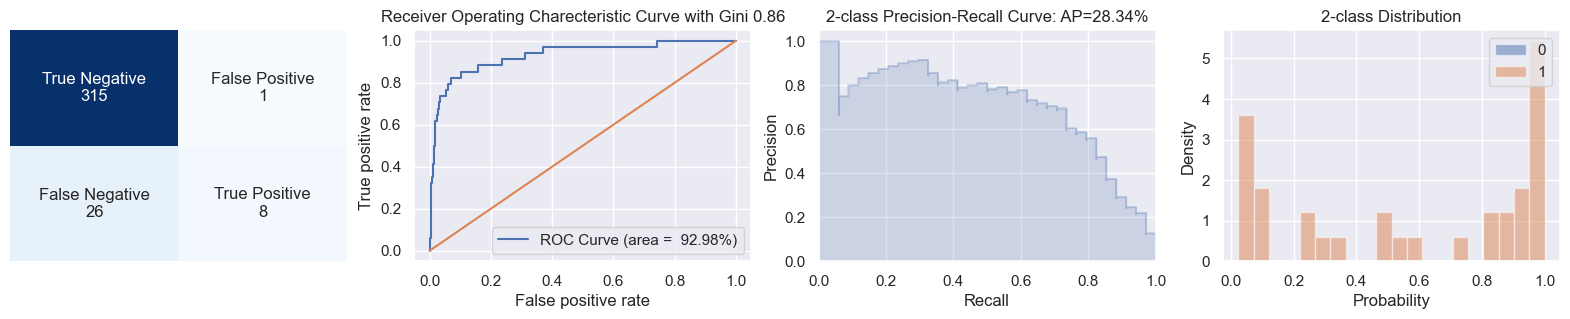

In [7]:
y_pred,ACC,PC,RC,FS,AP,roc_auc,gini = print_classification_performance2class_report(tuned_svm_model,valid_data,valid_labels)

>       Decision Trees - Hyperparameter Optimization

In [10]:
from sklearn.tree import DecisionTreeClassifier

clf = DecisionTreeClassifier()
clf.get_params()

{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'random_state': None,
 'splitter': 'best'}

In [14]:
# Set the logging level for Optuna to WARNING
# logging.getLogger('optuna').setLevel(logging.WARNING) 
import optuna
from sklearn.model_selection import cross_val_score

def objective(trial):
    # Define the hyperparameters' search space
    criterion = trial.suggest_categorical('criterion', ['gini', 'entropy'])
    max_depth = trial.suggest_int('max_depth', 1, 32)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 20)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 20)

    # Create the Decision Tree model with suggested hyperparameters
    model = DecisionTreeClassifier(
        criterion=criterion, 
        max_depth=max_depth, 
        min_samples_split=min_samples_split, 
        min_samples_leaf=min_samples_leaf
    )

    # Perform cross-validation and compute the average AUC score
    scores = cross_val_score(model, train_data, train_labels, scoring='roc_auc', n_jobs=-1, cv=10)
    avg_auc_test = np.mean(scores)

    return avg_auc_test


# Create and run the study
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100) 

# Best hyperparameters
best_hyperparams = study.best_trial.params
# print('Best Hyperparameters:', best_hyperparams)

[I 2023-12-05 08:09:15,789] A new study created in memory with name: no-name-4e161133-d0e5-4c9e-8bf8-a1e0abb730c6


[I 2023-12-05 08:12:42,953] Trial 0 finished with value: 0.7316388413242008 and parameters: {'criterion': 'gini', 'max_depth': 23, 'min_samples_split': 6, 'min_samples_leaf': 18}. Best is trial 0 with value: 0.7316388413242008.
[I 2023-12-05 08:13:25,960] Trial 1 finished with value: 0.798881380463144 and parameters: {'criterion': 'gini', 'max_depth': 7, 'min_samples_split': 9, 'min_samples_leaf': 8}. Best is trial 1 with value: 0.798881380463144.
[I 2023-12-05 08:14:06,355] Trial 2 finished with value: 0.715470924385736 and parameters: {'criterion': 'gini', 'max_depth': 28, 'min_samples_split': 20, 'min_samples_leaf': 20}. Best is trial 1 with value: 0.798881380463144.
[I 2023-12-05 08:15:05,535] Trial 3 finished with value: 0.7609412372254838 and parameters: {'criterion': 'gini', 'max_depth': 18, 'min_samples_split': 3, 'min_samples_leaf': 1}. Best is trial 1 with value: 0.798881380463144.
[I 2023-12-05 08:15:44,504] Trial 4 finished with value: 0.7518144229723853 and parameters: {'c

In [16]:
from joblib import dump, load

best_criterion = best_hyperparams['criterion']
best_max_depth = best_hyperparams['max_depth']
best_min_samples_split = best_hyperparams['min_samples_split']
best_min_samples_leaf = best_hyperparams['min_samples_leaf']

print("Best Criterion: {}".format(best_criterion))
print("Best max depth: {}".format(best_max_depth))
print("Best min samples split: {}".format(best_min_samples_split))
print("Best min samples leaf: {}".format(best_min_samples_leaf))


# Create the Decision Tree model with the best hyperparameters
tuned_dt_model = DecisionTreeClassifier(
    criterion=best_criterion,
    max_depth=best_max_depth,
    min_samples_split=best_min_samples_split,
    min_samples_leaf=best_min_samples_leaf
)

# Train the model using the entire dataset
tuned_dt_model.fit(train_data, train_labels)


dump(tuned_dt_model, 'models/tuned_model/tuned_decision_tree.joblib')



Best Criterion: entropy
Best max depth: 22
Best min samples split: 13
Best min samples leaf: 5


['models/tuned_model/tuned_decision_tree.joblib']

Accuracy: 92.00%
Precision: 65.00%
Sensitivity (Recall): 38.24%
Specificity: 97.78%
Fscore: 48.15%
Average precision: 30.85%
G-Mean: 61.15%
ROC AUC: 82.28%


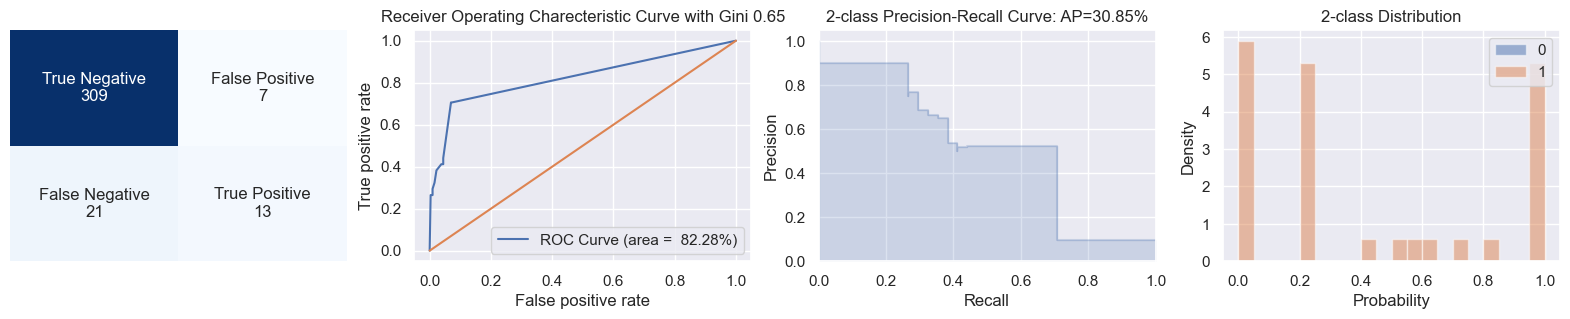

In [17]:
y_pred,ACC,PC,RC,FS,AP,roc_auc,gini = print_classification_performance2class_report(tuned_dt_model,valid_data,valid_labels)

<a id="6"></a> <br>
## Feature Selection and Retraining Model

>       Feature Selection

> Feature selection and feature extraction techniques are used to improve model generalization by reducing the complexity of the model or extracting more informative representations


| Feature Selection Techniques   | Characteristics |
|--------------------------------|-----------------|
| Variance Threshold            | - This method removes all features whose variance doesn’t meet some threshold. Since the Dorothea dataset is binary, using a variance threshold can help remove features that have little variance and are therefore less informative |
| Chi-squared (Chi2) (Univariate Feature Selection)          | - Investigate dependence of variables on response<br>- Effective with large datasets |
| Recursive feature elimination (RFE) | - Searches and ranks features<br>- Actively removes low-ranking features until desired features remain |
| Principal component analysis (PCA) | - Selects features based on coefficient values<br>- Reduces dimensions of the dataset while maintaining variance between features |


In [26]:
from sklearn.feature_selection import VarianceThreshold

def select_features_variance_threshold(train_X, valid_X):
    # Calculate the threshold based on the formula provided
    threshold = 0.1 * (0.2 * 0.8)
    
    # Create the VarianceThreshold feature selector
    selector = VarianceThreshold(threshold=threshold)
    
    # Fit the selector on the training dataset and transform both train and valid datasets
    train_X_selected = selector.fit_transform(train_X)
    valid_X_selected = selector.transform(valid_X)
    
    return train_X_selected, valid_X_selected


train_data_new, valid_data_new = select_features_variance_threshold(train_data, valid_data)



> Testing the Optimized Model on the selected Features

Logistic Model
Accuracy: 93.14%
Precision: 77.78%
Sensitivity (Recall): 41.18%
Specificity: 98.73%
Fscore: 53.85%
Average precision: 37.74%
G-Mean: 63.76%
ROC AUC: 82.30%


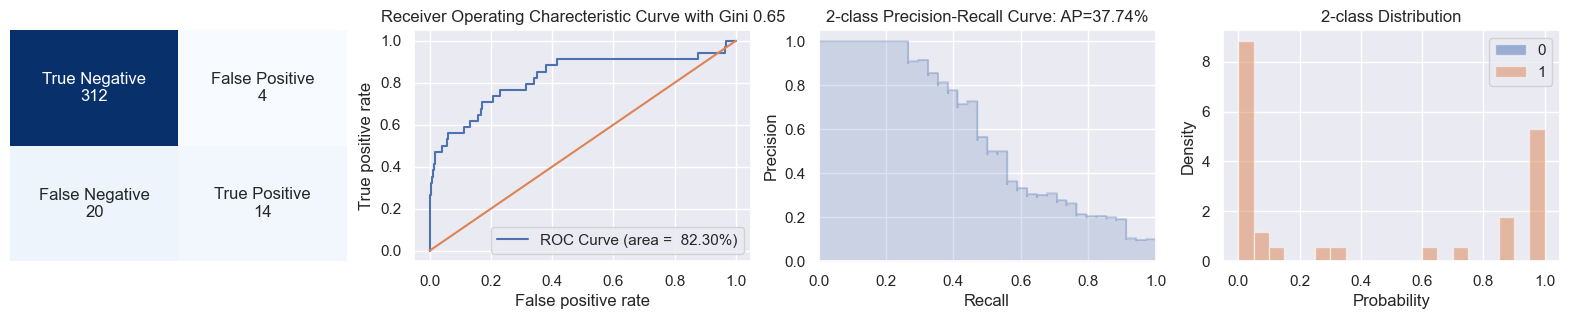

['models/tuned_model_fs/tuned_logistic_regression.joblib']

In [27]:
log_tuned_model_fs = LogisticRegression(C=best_C_log, penalty=best_penalty, solver=best_solver, max_iter=best_max_iter)
log_tuned_model_fs.fit(train_data_new, train_labels)


print("Logistic Model")
y_pred,ACC,PC,RC,FS,AP,roc_auc,gini = print_classification_performance2class_report(log_tuned_model_fs,valid_data_new,valid_labels)
dump(log_tuned_model_fs, 'models/tuned_model_fs/tuned_logistic_regression.joblib')

Support Vector Model
Accuracy: 94.00%
Precision: 93.33%
Sensitivity (Recall): 41.18%
Specificity: 99.68%
Fscore: 57.14%
Average precision: 44.15%
G-Mean: 64.07%
ROC AUC: 85.94%


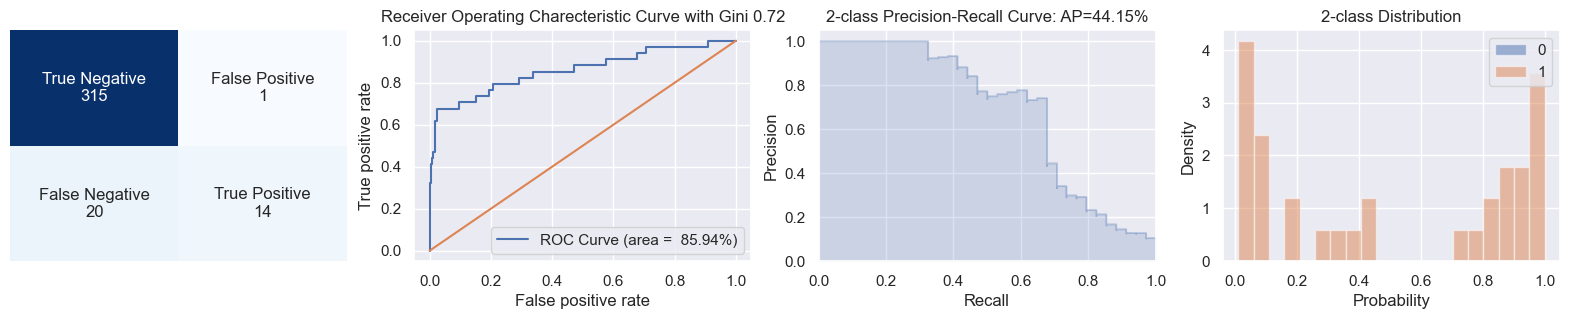

['models/tuned_model_fs/tuned_support_vector_fs.joblib']

In [10]:
tuned_svm_model_fs = SVC(C=best_C_svm, kernel=best_kernel, gamma=best_gamma, probability=True)
tuned_svm_model_fs.fit(train_data_new, train_labels)


print("Support Vector Model")
y_pred,ACC,PC,RC,FS,AP,roc_auc,gini = print_classification_performance2class_report(tuned_svm_model_fs,valid_data_new,valid_labels)
dump(tuned_svm_model_fs, 'models/tuned_model_fs/tuned_support_vector_fs.joblib')

Decision Tree Model
Accuracy: 93.14%
Precision: 75.00%
Sensitivity (Recall): 44.12%
Specificity: 98.42%
Fscore: 55.56%
Average precision: 38.52%
G-Mean: 65.89%
ROC AUC: 80.30%


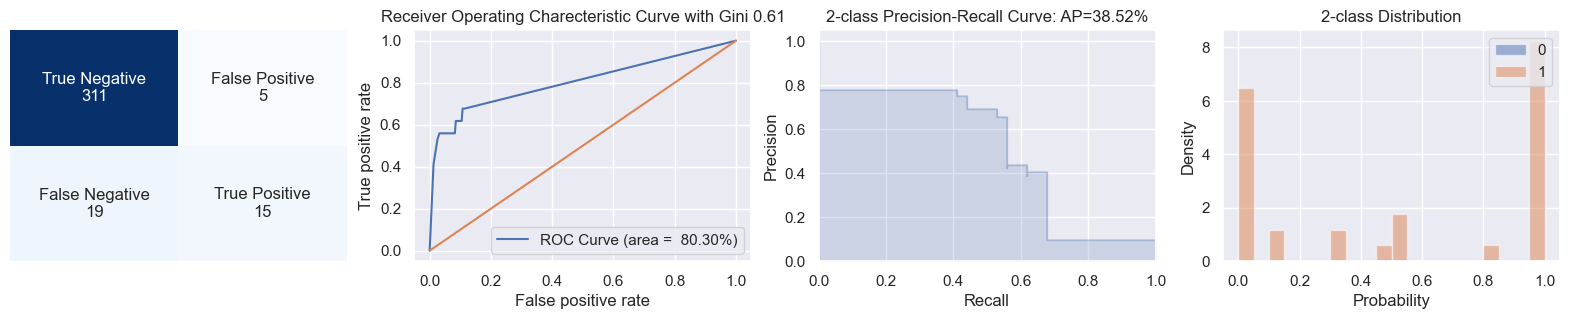

['models/tuned_model_fs/tuned_decision_tree_fs.joblib']

In [23]:
# Create the Decision Tree model with the best hyperparameters
tuned_dt_model_fs = DecisionTreeClassifier(
    criterion=best_criterion,
    max_depth=best_max_depth,
    min_samples_split=best_min_samples_split,
    min_samples_leaf=best_min_samples_leaf
)

# Train the model using the entire dataset
tuned_dt_model_fs.fit(train_data_new, train_labels)

print("Decision Tree Model")
y_pred,ACC,PC,RC,FS,AP,roc_auc,gini = print_classification_performance2class_report(tuned_dt_model_fs,valid_data_new,valid_labels)
dump(tuned_dt_model_fs, 'models/tuned_model_fs/tuned_decision_tree_fs.joblib')